## Import and Definitions

In [1]:
import numpy as np

# https://github.com/ppark-twosixtech/armory/tree/f02438d81d0681b9bc1d456935fd81ac15731fbc
from armory.metrics import task
from tidecv import TIDE
import tidecv.data

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

2022-11-22 16:20:40  0s INFO     armory.delayed_imports:<module>:7 Importing and configuring torch, tensorflow, and art, if available. This may take some time.
2022-11-22 16:20:42  3s INFO     armory.delayed_imports:<module>:30 Setting tf.config.experimental.set_memory_growth to True on all GPUs
2022-11-22 16:20:42  3s INFO     art.config:set_data_path:55 set ART_DATA_PATH to /tmp/.art/data
2022-11-22 16:20:42  3s INFO     art.config:set_data_path:55 set ART_DATA_PATH to /armory/saved_models/art


In [2]:
def generate_square(x1, y1, l=10):
    return x1, y1, x1+l, y1+l

In [3]:
def generate_square_from_iou(square, iou, x3, y3_le_y1=True):
    x1, y1, x2, y2 = square
    l = x2 - x1    # side of a square
    A1 = A2 = l**2 # restrict to squares of the same size
    
    if x3 <= x1:
        s_x = 1
    else:
        s_x = -1
        
    if y3_le_y1:
        s_y = 1
    else:
        s_y = -1
        
    # in this restricted problem, delta_x needs to satisfy certain constraints
    delta_x = abs(x1 - x3)
    max_delta_x = l*(1 - iou)/(1 + iou)
    print(f"delta_x <= {max_delta_x}: {delta_x <= max_delta_x}")
    
    # y3 = s_y*(iou*(A1 + A2)/(1 + iou)/(l + s_x*(x3 - x1)) - (l - s_y*y1))
    # y3 = s_y*(iou*(A1 + A2)/(1 + iou)/(l - s_x*(x1 - x3)) - (l - s_y*y1))
    # y3 = s_y*(iou*(A1 + A2)/(1 + iou)/(l - abs(x1 - x3)) - (l - s_y*y1))
    y3 = y1 + s_y*(iou*(A1 + A2)/(1 + iou)/(l - delta_x) - l)
    
    if (not y3_le_y1 and y3 > y1) or (y3_le_y1 and y3 <= y1):
        return x3, y3, x3+l, y3+l
    else:
        return None

In [4]:
def calculate_iou(s1, s2):
    x1, y1, x2, y2 = s1
    x3, y3, x4, y4 = s2
    
    A1 = abs(x2 - x1) * abs(y2 - y1)
    A2 = abs(x4 - x3) * abs(y4 - y3)
    
    I_w = max(0, min(max(x1,x2), max(x3,x4)) - max(min(x1,x2), min(x3,x4)))
    I_h = max(0, min(max(y1,y2), max(y3,y4)) - max(min(y1,y2), min(y3,y4)))
    I = I_w * I_h
    
    # I = abs(min(max(x1,x2), max(x3,x4)) - max(min(x1,x2), min(x3,x4))) * abs(min(max(y1,y2), max(y3,y4)) - max(min(y1,x2), min(y3,y4)))
    
    return np.round(I/(A1 + A2 - I), decimals=2), A1, A2, I_w, I_h, I

In [5]:
def get_patch(square, lw=2, ec="r", ls="-", fc="none", a=1):
    x = square[0]
    y = square[1]
    w = square[2]-square[0]
    h = square[3]-square[1]
    return patches.Rectangle((x, y), w, h, linewidth=lw, edgecolor=ec, linestyle=ls, facecolor=fc, alpha=a)

In [6]:
def get_detection_patch(square, c="r"):
    return get_patch(square, ec=c, ls=(5, (10, 3)))
    # return get_patch(square, ec=c, ls="--")

In [7]:
def get_gt_patch(square, c="r", a=0.5):
    # return get_patch(square, ec=c, fc=c)
    # return get_patch(square, lw=0, fc=c)
    return get_patch(square, lw=0, fc=c, a=a)
    # return get_patch(square, ec=c)

In [32]:
def dict_to_list(y_dict):
    return [dict(zip(y_dict, v)) for v in zip(*y_dict.values())]

def plot_tide_case(y_dict, y_pred_dict, class_color_map={1: "cyan", 2: "magenta", 3: "yellow"}):
    y_list = dict_to_list(y_dict)
    y_pred_list = dict_to_list(y_pred_dict)
    
    # # fig = plt.figure(figsize=(16,6))
    # fig = plt.figure(figsize=(16,11))
    # fs = 20
    # # fig = plt.figure(figsize=(8,3))
    fig = plt.figure(figsize=(8,5.5))
    fs = 10
    # fig = plt.figure(figsize=(9.6,6.6))
    # fs = 12
    ax = fig.add_axes([0, 0, 1, 1])
    
    # Create patch
    gt_patch_list = [get_gt_patch(y["boxes"], class_color_map[y["labels"]]) for y in y_list]
    detection_patch_list = [get_detection_patch(y["boxes"], class_color_map[y["labels"]]) for y in y_pred_list]

    # Add the patch to the Axes
    for patch in gt_patch_list + detection_patch_list:
        ax.add_patch(patch)
        
    for y_pred in y_pred_list:
        s_gt = y_list[y_pred["max_IOU_idx"]]["boxes"]
        s_pred = y_pred["boxes"]
        annotation_xy = y_pred["annotation_xy"]
        c_pred = class_color_map[y_pred["labels"]]
        ax.annotate(calculate_iou(s_gt, s_pred)[0], annotation_xy, size=fs, color=c_pred)
    
    ax.set_xlim(0,80)
    # ax.set_ylim(0,30)
    ax.set_ylim(0,55)

## Generate Boxes

In [9]:
x1 = 10
y1 = 35

s0 = generate_square(x1,y1)
s_Cls = generate_square_from_iou(s0, 0.8, x1-0.5)
print(s_Cls, calculate_iou(s0, s_Cls))

y2 = y1 - 25
s1 = generate_square(x1,y2)
s_Loc = generate_square_from_iou(s1, 0.2, x1-4.5)
print(s_Loc, calculate_iou(s1, s_Loc))

x2 = x1 + 25
s2 = generate_square(x2,y1)
s_Both = generate_square_from_iou(s2, 0.2, x2-4.5)
print(s_Both, calculate_iou(s2, s_Both))

s3 = generate_square(x2,y2)
s_Bkg = generate_square_from_iou(s3, 0.05, x2-6.8)
print(s_Bkg, calculate_iou(s3, s_Bkg))

x3 = x2 + 25
s4 = generate_square(x3,y1)
s_detected = generate_square_from_iou(s4, 0.8, x3+0.5, False)
print(s_detected, calculate_iou(s4, s_detected))
s_Dupe = generate_square_from_iou(s4, 0.55, x3-2)
print(s_Dupe, calculate_iou(s4, s_Dupe))

s5 = generate_square(x3,y2)

# class_color_map={0: "cyan", 1: "magenta", 2: "yellow", 3: "b", 4: "r", 5: "g"}
class_color_map={0: "cyan", 1: "magenta", 2: "g", 3: "b", 4: "r", 5: "yellow"}

delta_x <= 1.111111111111111: True
(9.5, 34.356725146198826, 19.5, 44.356725146198826) (0.8, 100, 100.0, 9.5, 9.356725146198826, 88.88888888888886)
delta_x <= 6.666666666666667: True
(5.5, 6.060606060606061, 15.5, 16.060606060606062) (0.2, 100, 100.0, 5.5, 6.060606060606062, 33.33333333333334)
delta_x <= 6.666666666666667: True
(30.5, 31.060606060606062, 40.5, 41.06060606060606) (0.2, 100, 100.0, 5.5, 6.060606060606062, 33.33333333333334)
delta_x <= 9.047619047619047: True
(28.2, 2.9761904761904763, 38.2, 12.976190476190476) (0.05, 100, 100.00000000000003, 3.200000000000003, 2.9761904761904763, 9.523809523809533)
delta_x <= 1.111111111111111: True
(60.5, 35.643274853801174, 70.5, 45.643274853801174) (0.8, 100, 100.0, 9.5, 9.356725146198826, 88.88888888888886)
delta_x <= 2.903225806451613: True
(58, 33.87096774193549, 68, 43.87096774193549) (0.55, 100, 100.0, 8, 8.870967741935488, 70.9677419354839)


## Test Case: `mAP = 17`

In [10]:
y_list = [
        {
        "labels": np.arange(6),
        "boxes": np.array(
            [
                s0,
                s1,
                s2,
                s3,
                s4,
                s5,
            ]
        ),
    }
]

y_pred_list = [
    {
        "labels": np.array([1, 1, 3, 3, 4, 4]),
        "boxes": np.array(
            [
                s_Cls,
                s_Loc,
                s_Both,
                s_Bkg,
                s_detected,
                s_Dupe,
            ]
        ),
        "scores": np.array([0.8, 0.8, 0.8, 0.8, 0.8, 0.8]),
        "max_IOU_idx": [0, 1, 2, 3, 4, 4],
        "annotation_xy": [
            (s_Cls[0], s_Cls[1] - 1.5),
            (s_Loc[0], s_Loc[1] - 1.5),
            (s_Both[0], s_Both[1] - 1.5),
            (s_Bkg[0], s_Bkg[1] - 1.5),
            (s_detected[0], s_detected[3] + 0.5),
            (s_Dupe[0], s_Dupe[1] - 1.5),
        ]
    }
]

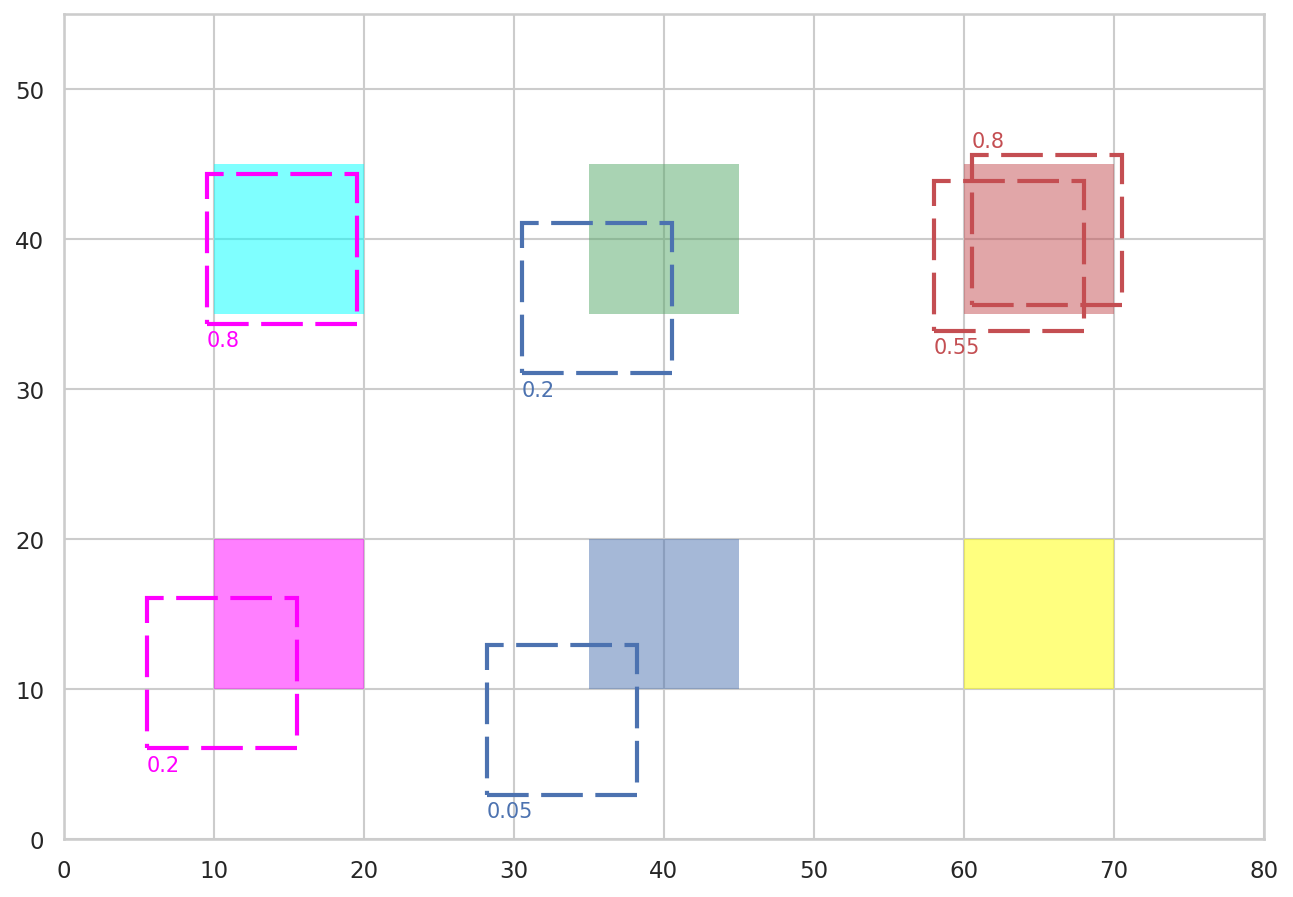

In [33]:
plot_tide_case(y_list[0], y_pred_list[0], class_color_map)

In [45]:
armory_output, tide = task.object_detection_mAP_tide(y_list, y_pred_list, True)
print(f"""error count:  {armory_output["errors"]["main"]["count"]}, {armory_output["errors"]["special"]["count"]}""")
print(f"AP per class: {task.object_detection_AP_per_class(y_list, y_pred_list)}")
tide.summarize()

error count:  {'Cls': 1, 'Loc': 1, 'Both': 1, 'Dupe': 1, 'Bkg': 1, 'Miss': 3}, {'FalseNeg': 5}
AP per class: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 1.0, 5: 0.0}
-- detection --

bbox AP @ [50-95]: 10.00
                                         bbox AP @ [50-95]
  Thresh       50       55       60       65       70       75       80       85       90       95  
---------------------------------------------------------------------------------------------------
    AP      16.67    16.67    16.67    16.67    16.67    16.67     0.00     0.00     0.00     0.00  

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP     8.33     0.00     0.00     0.00     0.00     0.00  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       0.00       0.00  



## Fix Classification Error: `dAP = 16`
> **Classification Error**: *IoU*<sub>max</sub> &ge; *t*<sub>f</sub> for GT of the *incorrect* class (i.e., localized correctly but classified incorrectly).

> **Classification Oracle**: Correct the class of the detection (thereby making it a true positive). If a duplicate detection would be made this way, suppress the lower scoring detection.

In [20]:
y_pred_list_Cls = [
    {
        "labels": np.array([0, 1, 3, 3, 4, 4]),
        "boxes": np.array(
            [
                s_Cls,
                s_Loc,
                s_Both,
                s_Bkg,
                s_detected,
                s_Dupe,
            ]
        ),
        "scores": np.array([0.8, 0.8, 0.8, 0.8, 0.8, 0.8]),
        "max_IOU_idx": [0, 1, 2, 3, 4, 4],
        "annotation_xy": [
            (s_Cls[0], s_Cls[1] - 1.5),
            (s_Loc[0], s_Loc[1] - 1.5),
            (s_Both[0], s_Both[1] - 1.5),
            (s_Bkg[0], s_Bkg[1] - 1.5),
            (s_detected[0], s_detected[3] + 0.5),
            (s_Dupe[0], s_Dupe[1] - 1.5),
            
        ]
    }
]

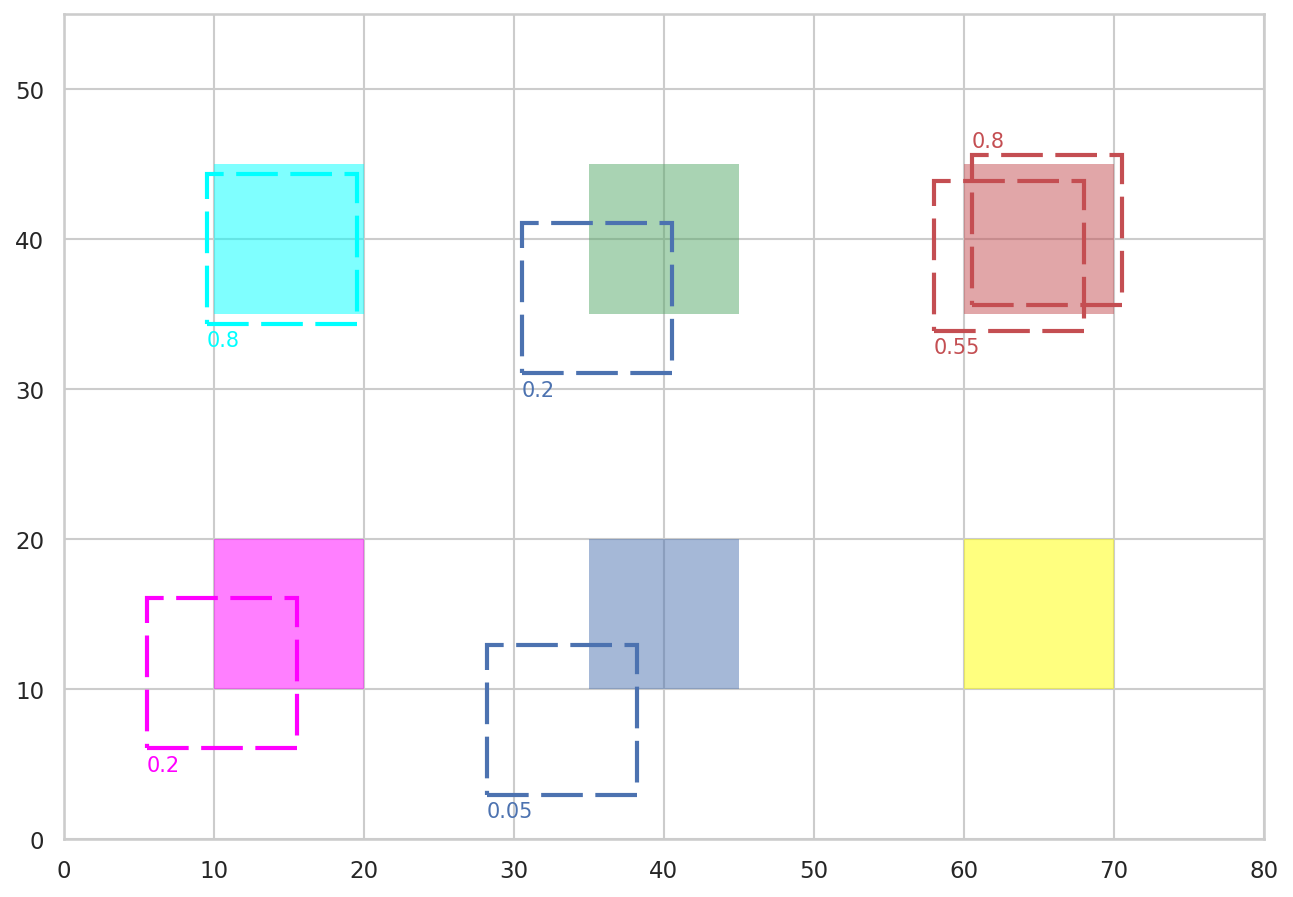

In [25]:
plot_tide_case(y_list[0], y_pred_list_Cls[0], class_color_map)

In [46]:
armory_output_Cls, tide_Cls = task.object_detection_mAP_tide(y_list, y_pred_list_Cls, True)
print(f"""error count:  {armory_output_Cls["errors"]["main"]["count"]}, {armory_output_Cls["errors"]["special"]["count"]}""")
print(f"AP per class: {task.object_detection_AP_per_class(y_list, y_pred_list_Cls)}")
tide_Cls.summarize()

error count:  {'Cls': 0, 'Loc': 1, 'Both': 1, 'Dupe': 1, 'Bkg': 1, 'Miss': 3}, {'FalseNeg': 4}
AP per class: {0: 1.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 1.0, 5: 0.0}
-- detection --

bbox AP @ [50-95]: 20.00
                                         bbox AP @ [50-95]
  Thresh       50       55       60       65       70       75       80       85       90       95  
---------------------------------------------------------------------------------------------------
    AP      33.33    33.33    33.33    33.33    33.33    33.33     0.00     0.00     0.00     0.00  

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP     0.00     8.33     0.00     0.00     0.00     4.17  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       0.00       4.17  



## Fix Localization Error: `dAP = 8`
> **Localization Error**: *t*<sub>b</sub> &le; *IoU*<sub>max</sub> &le; *t*<sub>f</sub> for GT of the *correct* class (i.e., classified correctly but localized incorrectly).

> **Localization Oracle**: Set the localization of the detection to the GT’s localization (thereby making it a true positive). Again, if a duplicated detection would be made this way, suppress the lower scoring detection.

In [37]:
y_pred_list_Loc = [
    {
        "labels": np.array([1, 1, 3, 3, 4, 4]),
        "boxes": np.array(
            [
                s_Cls,
                s1,
                s_Both,
                s_Bkg,
                s_detected,
                s_Dupe,
            ]
        ),
        "scores": np.array([0.8, 0.8, 0.8, 0.8, 0.8, 0.8]),
        "max_IOU_idx": [0, 1, 2, 3, 4, 4],
        "annotation_xy": [
            (s_Cls[0], s_Cls[1] - 1.5),
            (s1[0], s1[1] - 1.5),
            (s_Both[0], s_Both[1] - 1.5),
            (s_Bkg[0], s_Bkg[1] - 1.5),
            (s_detected[0], s_detected[3] + 0.5),
            (s_Dupe[0], s_Dupe[1] - 1.5),
            
        ]
    }
]

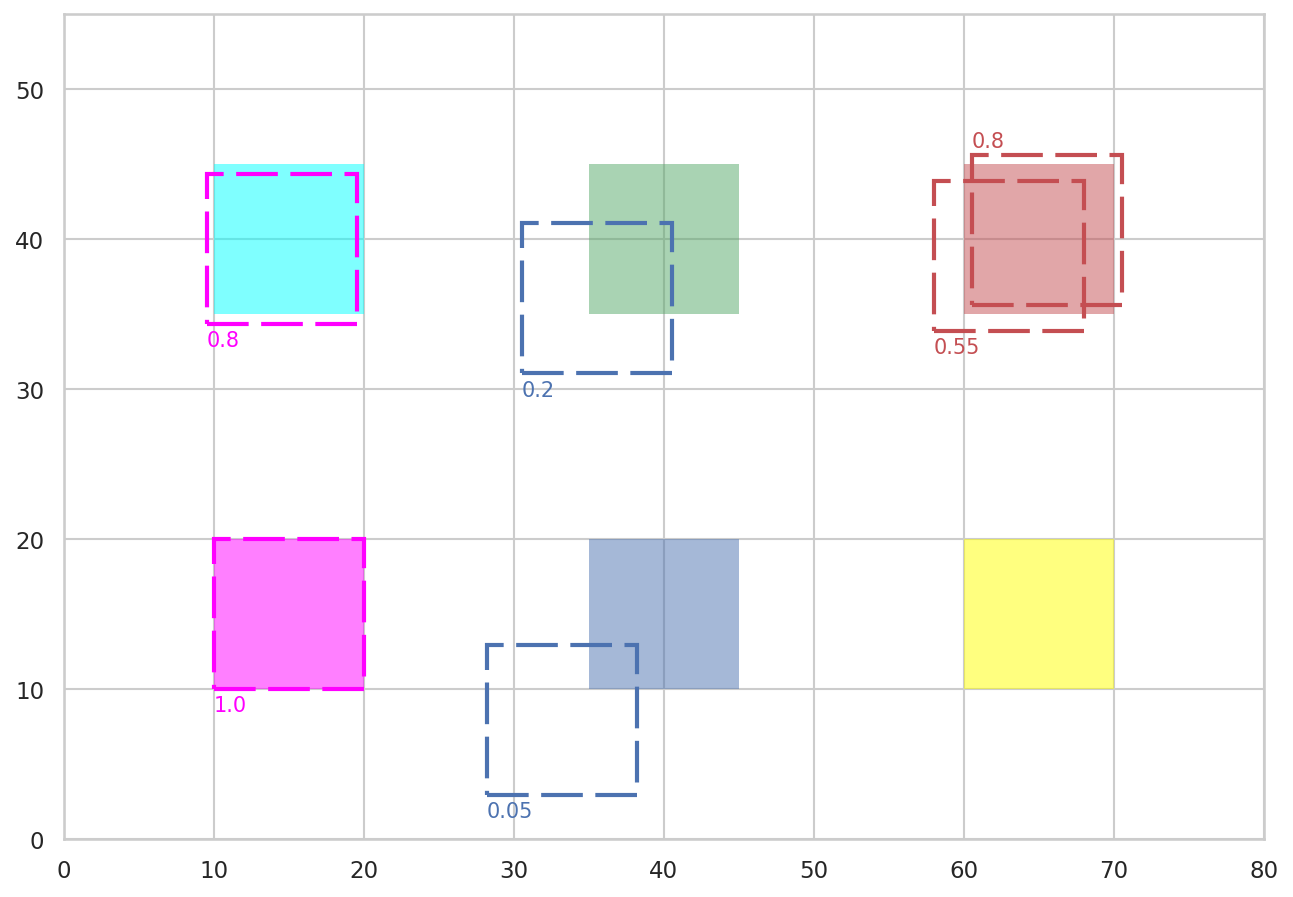

In [38]:
plot_tide_case(y_list[0], y_pred_list_Loc[0], class_color_map)

In [47]:
armory_output_Loc, tide_Loc = task.object_detection_mAP_tide(y_list, y_pred_list_Loc, True)
print(f"""error count:  {armory_output_Loc["errors"]["main"]["count"]}, {armory_output_Loc["errors"]["special"]["count"]}""")
print(f"AP per class: {task.object_detection_AP_per_class(y_list, y_pred_list_Loc)}")
tide_Loc.summarize()

error count:  {'Cls': 1, 'Loc': 0, 'Both': 1, 'Dupe': 1, 'Bkg': 1, 'Miss': 3}, {'FalseNeg': 4}
AP per class: {0: 0.0, 1: 0.5, 2: 0.0, 3: 0.0, 4: 1.0, 5: 0.0}
-- detection --

bbox AP @ [50-95]: 18.33
                                         bbox AP @ [50-95]
  Thresh       50       55       60       65       70       75       80       85       90       95  
---------------------------------------------------------------------------------------------------
    AP      25.00    25.00    25.00    25.00    25.00    25.00     8.33     8.33     8.33     8.33  

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP    16.67     0.00     0.00     0.00     0.00     0.00  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       8.33       8.33  



## Fix Both Error: `dAP = 0`
> **Both Cls and Loc Error**: *t*<sub>b</sub> &le; *IoU*<sub>max</sub> &le; *t*<sub>f</sub> for GT of the *incorrect* class (i.e., classified incorrectly *and* localized incorrectly).

> **Both Cls and Loc Oracle**: Since we cannot be sure of which GT the detector was attempting to match to, just suppress the false positive detection.

In [48]:
y_pred_list_Both = [
    {
        "labels": np.array([1, 1, 3, 4, 4]),
        "boxes": np.array(
            [
                s_Cls,
                s_Loc,
                s_Bkg,
                s_detected,
                s_Dupe,
            ]
        ),
        "scores": np.array([0.8, 0.8, 0.8, 0.8, 0.8]),
        "max_IOU_idx": [0, 1, 3, 4, 4],
        "annotation_xy": [
            (s_Cls[0], s_Cls[1] - 1.5),
            (s_Loc[0], s_Loc[1] - 1.5),
            (s_Bkg[0], s_Bkg[1] - 1.5),
            (s_detected[0], s_detected[3] + 0.5),
            (s_Dupe[0], s_Dupe[1] - 1.5),
            
        ]
    }
]

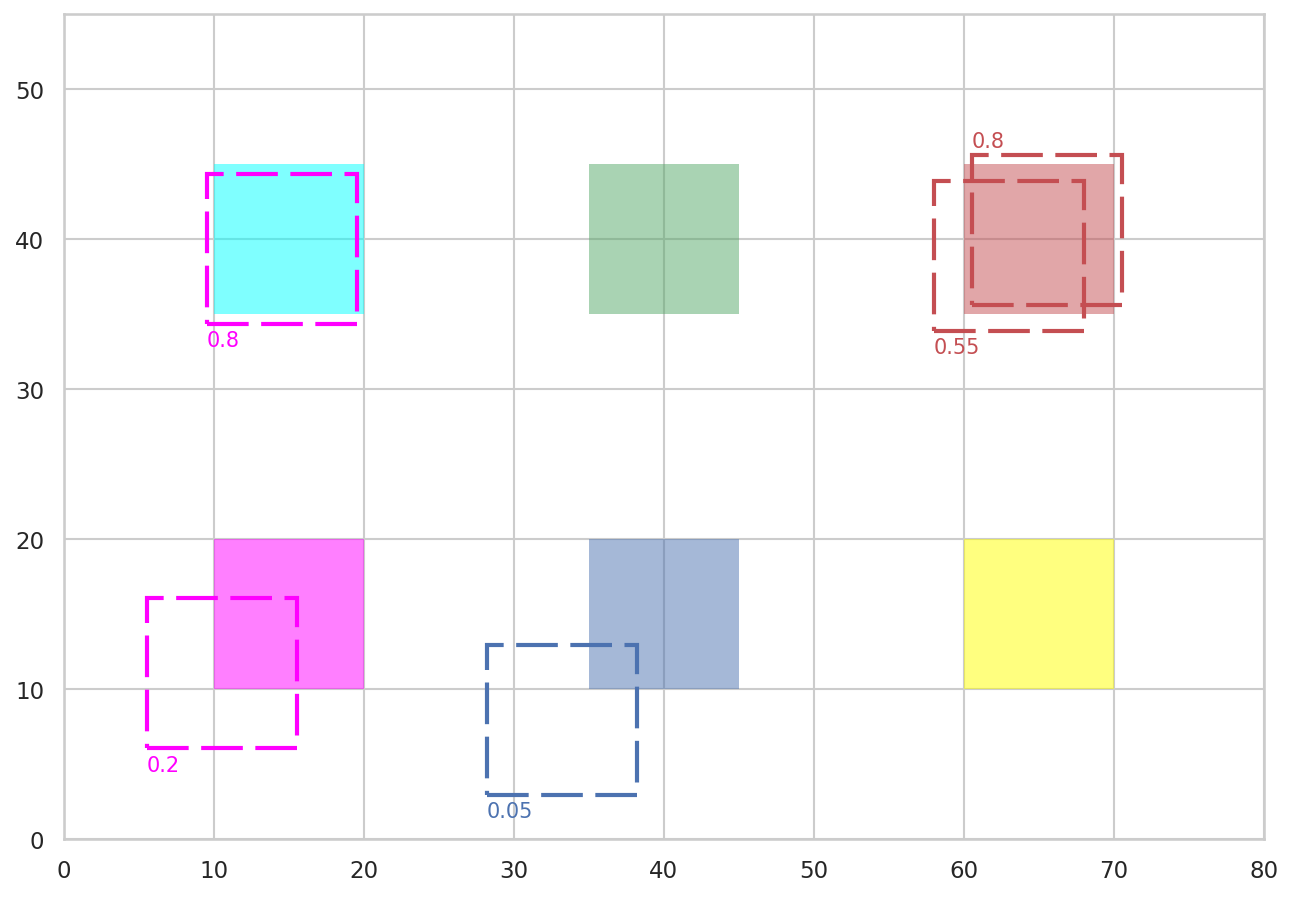

In [50]:
plot_tide_case(y_list[0], y_pred_list_Both[0], class_color_map)

In [51]:
armory_output_Both, tide_Both = task.object_detection_mAP_tide(y_list, y_pred_list_Both, True)
print(f"""error count: {armory_output_Both["errors"]["main"]["count"]}, {armory_output_Both["errors"]["special"]["count"]}""")
print(f"AP per class: {task.object_detection_AP_per_class(y_list, y_pred_list_Both)}")
tide_Both.summarize()

error count: {'Cls': 1, 'Loc': 1, 'Both': 0, 'Dupe': 1, 'Bkg': 1, 'Miss': 3}, {'FalseNeg': 5}
AP per class: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 1.0, 5: 0.0}
-- detection --

bbox AP @ [50-95]: 10.00
                                         bbox AP @ [50-95]
  Thresh       50       55       60       65       70       75       80       85       90       95  
---------------------------------------------------------------------------------------------------
    AP      16.67    16.67    16.67    16.67    16.67    16.67     0.00     0.00     0.00     0.00  

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP     8.33     0.00     0.00     0.00     0.00     0.00  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       0.00       0.00  



## Fix Duplication Error: `dAP = 0`
> **Duplicate Detection Error**: *IoU*<sub>max</sub> &ge; *t*<sub>f</sub> for GT of the *correct* class but another higher-scoring detection already matched that GT (i.e., would be correct if not for a higher scoring detection).

> **Duplicate Detection Oracle**: Suppress the duplicate detection.

In [56]:
y_pred_list_Dupe = [
    {
        "labels": np.array([1, 1, 3, 3, 4]),
        "boxes": np.array(
            [
                s_Cls,
                s_Loc,
                s_Both,
                s_Bkg,
                s_detected,
            ]
        ),
        "scores": np.array([0.8, 0.8, 0.8, 0.8, 0.8]),
        "max_IOU_idx": [0, 1, 2, 3, 4],
        "annotation_xy": [
            (s_Cls[0], s_Cls[1] - 1.5),
            (s_Loc[0], s_Loc[1] - 1.5),
            (s_Both[0], s_Both[1] - 1.5),
            (s_Bkg[0], s_Bkg[1] - 1.5),
            (s_detected[0], s_detected[3] + 0.5),
        ]
    }
]

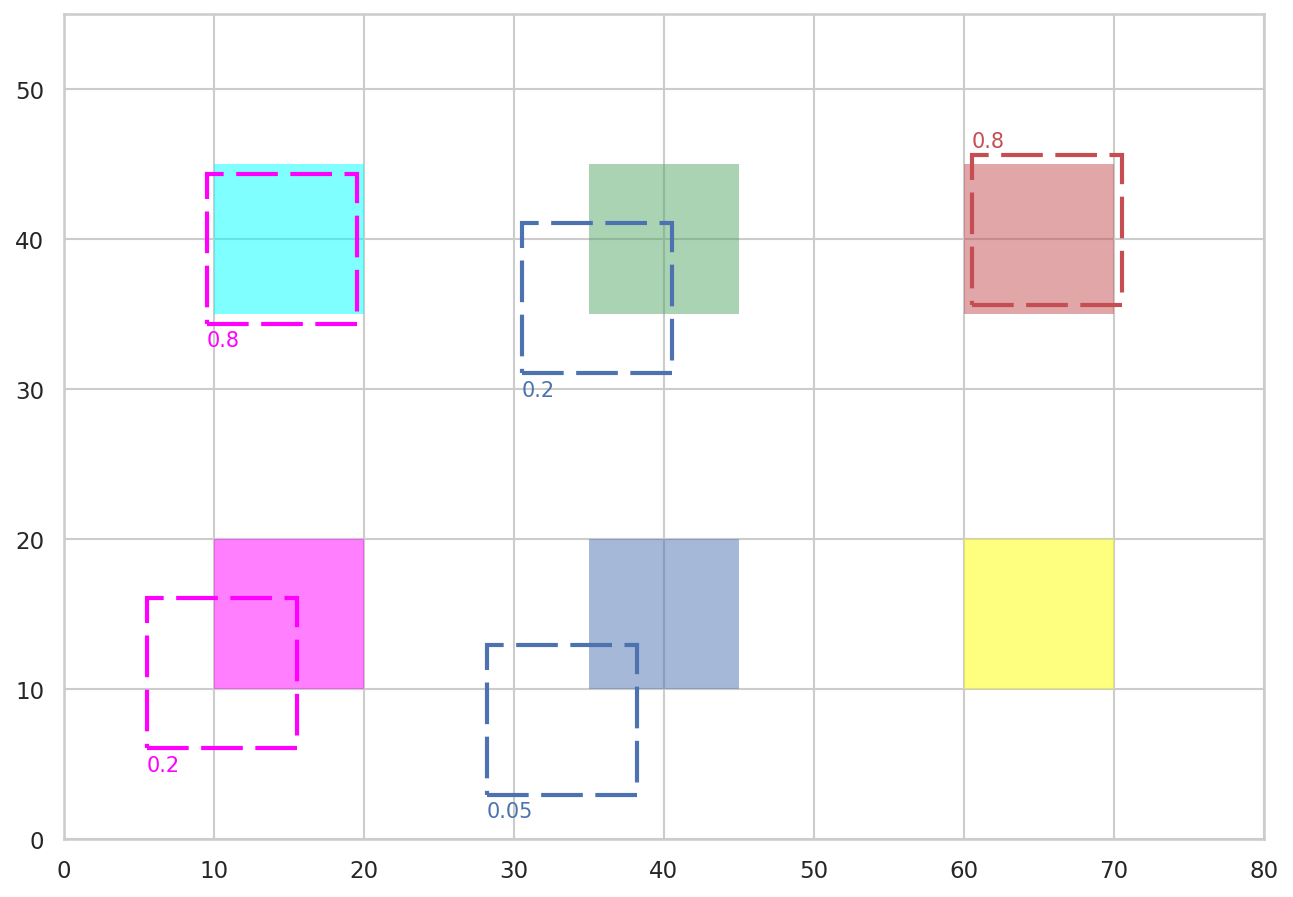

In [57]:
plot_tide_case(y_list[0], y_pred_list_Dupe[0], class_color_map)

In [58]:
armory_output_Dupe, tide_Dupe = task.object_detection_mAP_tide(y_list, y_pred_list_Dupe, True)
print(f"""error count:  {armory_output_Dupe["errors"]["main"]["count"]}, {armory_output_Dupe["errors"]["special"]["count"]}""")
print(f"AP per class: {task.object_detection_AP_per_class(y_list, y_pred_list_Dupe)}")
tide_Dupe.summarize()

error count:  {'Cls': 1, 'Loc': 1, 'Both': 1, 'Dupe': 0, 'Bkg': 1, 'Miss': 3}, {'FalseNeg': 5}
AP per class: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 1.0, 5: 0.0}
-- detection --

bbox AP @ [50-95]: 10.00
                                         bbox AP @ [50-95]
  Thresh       50       55       60       65       70       75       80       85       90       95  
---------------------------------------------------------------------------------------------------
    AP      16.67    16.67    16.67    16.67    16.67    16.67     0.00     0.00     0.00     0.00  

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP    16.67     8.33     0.00     0.00     0.00     8.33  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       0.00      16.67  



## Fix Background Error: `dAP = 0`
> **Background Error**: *IoU*<sub>max</sub> &le; *t*<sub>b</sub> for all GT (i.e., detected background as foreground).

> **Background Oracle**: Suppress the hallucinated background detection.

In [59]:
y_pred_list_Bkg = [
    {
        "labels": np.array([1, 1, 3, 4, 4]),
        "boxes": np.array(
            [
                s_Cls,
                s_Loc,
                s_Both,
                s_detected,
                s_Dupe,
            ]
        ),
        "scores": np.array([0.8, 0.8, 0.8, 0.8, 0.8]),
        "max_IOU_idx": [0, 1, 2, 4, 4],
        "annotation_xy": [
            (s_Cls[0], s_Cls[1] - 1.5),
            (s_Loc[0], s_Loc[1] - 1.5),
            (s_Both[0], s_Both[1] - 1.5),
            (s_detected[0], s_detected[3] + 0.5),
            (s_Dupe[0], s_Dupe[1] - 1.5),
        ]
    }
]

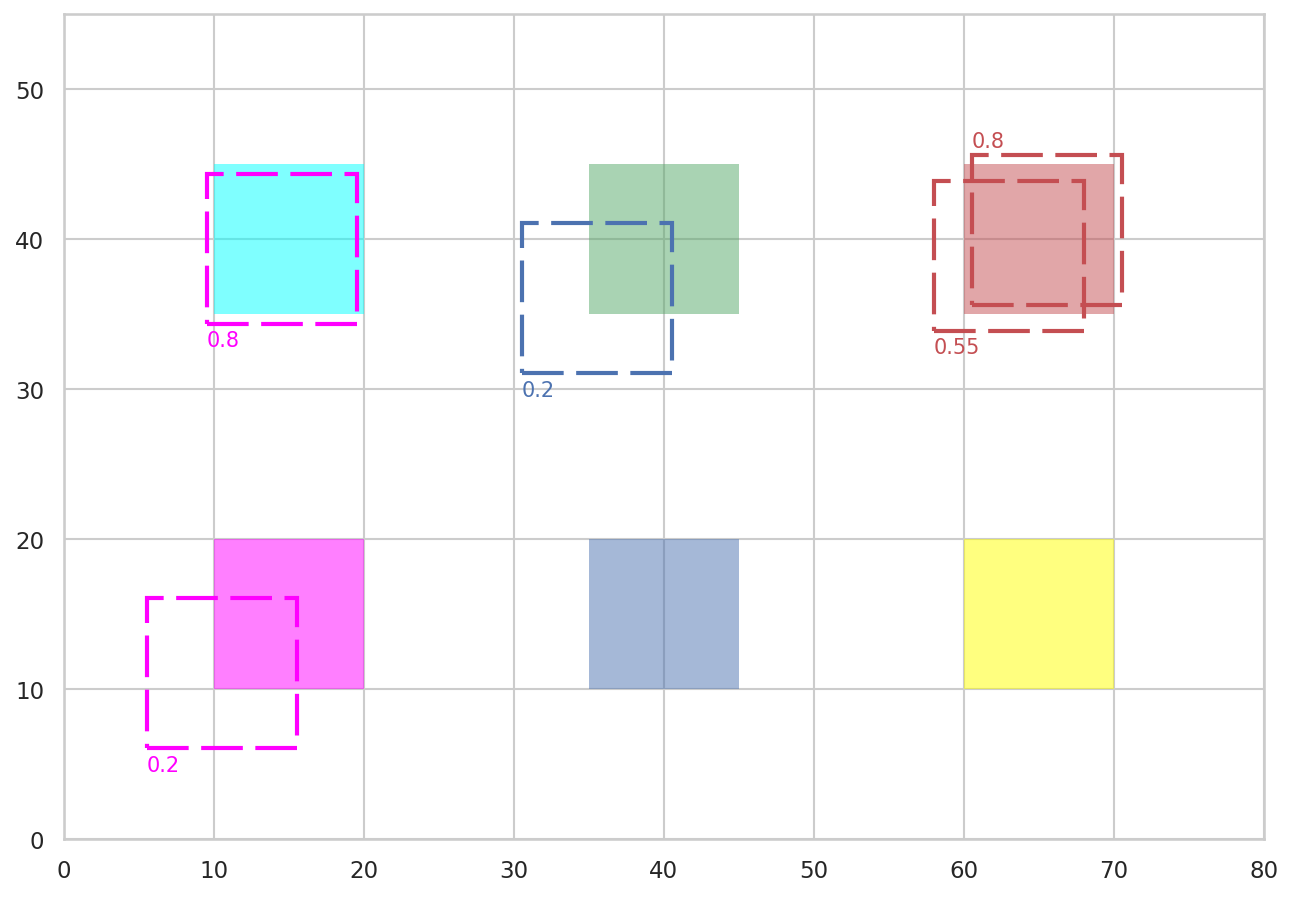

In [63]:
plot_tide_case(y_list[0], y_pred_list_Bkg[0], class_color_map)

In [64]:
armory_output_Bkg, tide_Bkg = task.object_detection_mAP_tide(y_list, y_pred_list_Bkg, True)
print(f"""error count:  {armory_output_Bkg["errors"]["main"]["count"]}, {armory_output_Bkg["errors"]["special"]["count"]}""")
print(f"AP per class: {task.object_detection_AP_per_class(y_list, y_pred_list_Bkg)}")
tide_Bkg.summarize()

error count:  {'Cls': 1, 'Loc': 1, 'Both': 1, 'Dupe': 1, 'Bkg': 0, 'Miss': 3}, {'FalseNeg': 5}
AP per class: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 1.0, 5: 0.0}
-- detection --

bbox AP @ [50-95]: 10.00
                                         bbox AP @ [50-95]
  Thresh       50       55       60       65       70       75       80       85       90       95  
---------------------------------------------------------------------------------------------------
    AP      16.67    16.67    16.67    16.67    16.67    16.67     0.00     0.00     0.00     0.00  

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP     8.33     0.00     0.00     0.00     0.00     0.00  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       0.00       0.00  



## Fix Missed Error: `dAP = 8`
> **Missed GT Error**: All undetected ground truth (false negatives) not already covered by classification or localization error.

> **Missed GT Oracle**: Reduce the number of GT (*N<sub>GT</sub>*) in the *mAP* calculation by the number of missed ground truth. This has the effect of stretching the precision-recall curve over a higher recall, essentially acting as if the detector was equally as precise on the missing GT. The alternative to this would be to add new detections, but it’s not clear what the score should be for that new detection such that it doesn’t introduce confounding variables. We discuss this choice further in the Appendix.

In [74]:
y_list_Miss = [
        {
        "labels": np.array([0, 1, 4]),
        "boxes": np.array(
            [
                s0,
                s1,
                s4,
            ]
        ),
    }
]

y_pred_list_Miss = [
    {
        "labels": np.array([1, 1, 3, 3, 4, 4]),
        "boxes": np.array(
            [
                s_Cls,
                s_Loc,
                s_Both,
                s_Bkg,
                s_detected,
                s_Dupe,
            ]
        ),
        "scores": np.array([0.8, 0.8, 0.8, 0.8, 0.8, 0.8]),
        "max_IOU_idx": [0, 1, 0, 1, 2, 2],
        "annotation_xy": [
            (s_Cls[0], s_Cls[1] - 1.5),
            (s_Loc[0], s_Loc[1] - 1.5),
            (s_Both[0], s_Both[1] - 1.5),
            (s_Bkg[0], s_Bkg[1] - 1.5),
            (s_detected[0], s_detected[3] + 0.5),
            (s_Dupe[0], s_Dupe[1] - 1.5),
        ]
    }
]

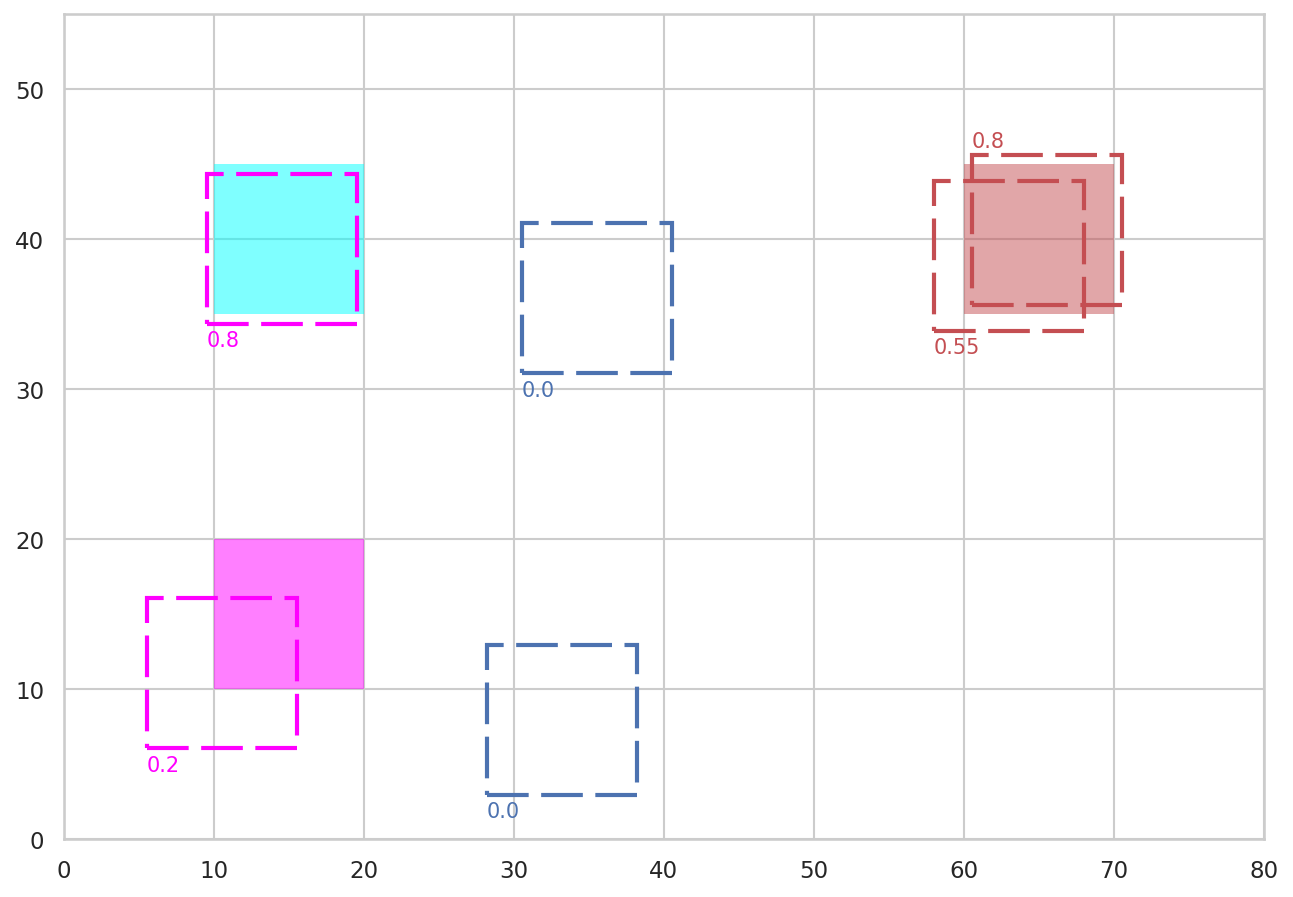

In [75]:
plot_tide_case(y_list_Miss[0], y_pred_list_Miss[0], class_color_map)

In [76]:
armory_output_Miss, tide_Miss = task.object_detection_mAP_tide(y_list_Miss, y_pred_list_Miss, True)
print(f"""error count:  {armory_output_Miss["errors"]["main"]["count"]}, {armory_output_Miss["errors"]["special"]["count"]}""")
print(f"AP per class: {task.object_detection_AP_per_class(y_list_Miss, y_pred_list_Miss)}")
tide_Miss.summarize()

error count:  {'Cls': 1, 'Loc': 1, 'Both': 0, 'Dupe': 1, 'Bkg': 2, 'Miss': 0}, {'FalseNeg': 2}
AP per class: {0: 0.0, 1: 0.0, 3: 0.0, 4: 1.0}
-- detection --

bbox AP @ [50-95]: 15.00
                                         bbox AP @ [50-95]
  Thresh       50       55       60       65       70       75       80       85       90       95  
---------------------------------------------------------------------------------------------------
    AP      25.00    25.00    25.00    25.00    25.00    25.00     0.00     0.00     0.00     0.00  

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP    12.50     0.00     0.00     0.00     0.00     0.00  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       0.00      -8.33  

